In [ ]:
import sys, os
!conda install --yes --prefix {sys.prefix} -c conda-forge openjdk=8
# In case of being already installed through pixi it should not be set to this path.
if 'JAVA_HOME' not in os.environ:
    os.environ['JAVA_HOME'] = os.sep.join(sys.executable.split(os.sep)[:-2] + ['jre'])
!{sys.executable} -m pip install multiscale-spatial-image matplotlib zarr pyimagej

In [1]:
from multiscale_spatial_image import to_multiscale
from spatial_image import is_spatial_image, to_spatial_image
import imagej
import zarr

In [ ]:
# initialize ImageJ2
ij = imagej.init('2.15.0')
print(f"ImageJ2 version: {ij.getVersion()}")

PyImageJ provides access to all the file formats supported by [Bio-Formats](https://www.openmicroscopy.org/bio-formats/) and [SCIFIO](https://scif.io/) through [Fiji](https://github.com/imagej/pyimagej/blob/master/doc/1-Starting-PyImageJ.ipynb).

Note that command line conversion to OME-NGFF via Bio-Formats is also available through the [bioformats2raw](https://github.com/glencoesoftware/bioformats2raw) CLI.

In [3]:
# Download example image
image = ij.io().open('https://wsr.imagej.net/images/Cell_Colony.jpg')
type(image)

[INFO] Populating metadata


<java class 'net.imagej.DefaultDataset'>

Convert the image to an xarray [DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html). For more information, see the [PyImageJ Working with Images tutorial](https://github.com/imagej/pyimagej/blob/master/doc/6-Working-with-Images.ipynb).

In [ ]:
image_da = ij.py.from_java(image)
image_da

In [6]:
is_spatial_image(image_da)

False

In [7]:
# Standard spatial_image dims
image_da = image_da.rename({'row':'y', 'col':'x'})

In [8]:
is_spatial_image(image_da)

True

In [9]:
# Clean attrs that are Java objects and cannot be serialized to Zarr
image_da.attrs.clear()
image_da

<xarray.DataArray 'Cell_Colony.jpg' (y: 408, x: 406)>
array([[160, 185, 208, ..., 192, 184, 166],
       [199, 215, 228, ..., 204, 196, 180],
       [226, 232, 236, ..., 212, 206, 193],
       ...,
       [203, 212, 216, ..., 167, 147, 143],
       [185, 198, 209, ..., 179, 163, 151],
       [156, 172, 189, ..., 191, 180, 164]], dtype=uint8)
Coordinates:
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 ... 403.0 404.0 405.0 406.0 407.0
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 401.0 402.0 403.0 404.0 405.0

In [10]:
image_da.attrs

{}

In [11]:
# The DataArray name needs to be set
image_da.name = str(image.getName())

In [12]:
multiscale = to_multiscale(image_da, [2,4])
print(multiscale)

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:          (y: 408, x: 406)
│       Coordinates:
│         * y                (y) float64 0.0 1.0 2.0 3.0 4.0 ... 404.0 405.0 406.0 407.0
│         * x                (x) float64 0.0 1.0 2.0 3.0 4.0 ... 402.0 403.0 404.0 405.0
│       Data variables:
│           Cell_Colony.jpg  (y, x) uint8 dask.array<chunksize=(256, 256), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:          (y: 204, x: 203)
│       Coordinates:
│         * y                (y) float64 0.5 2.5 4.5 6.5 8.5 ... 400.5 402.5 404.5 406.5
│         * x                (x) float64 0.5 2.5 4.5 6.5 8.5 ... 398.5 400.5 402.5 404.5
│       Data variables:
│           Cell_Colony.jpg  (y, x) uint8 dask.array<chunksize=(204, 203), meta=np.ndarray>
└── DataTree('scale2')
        Dimensions:          (y: 51, x: 50)
        Coordinates:
          * y                (y) float64 3.5 11.5 19.5 27.5 ... 379.5 387.5 395.5 403.5
          * x             

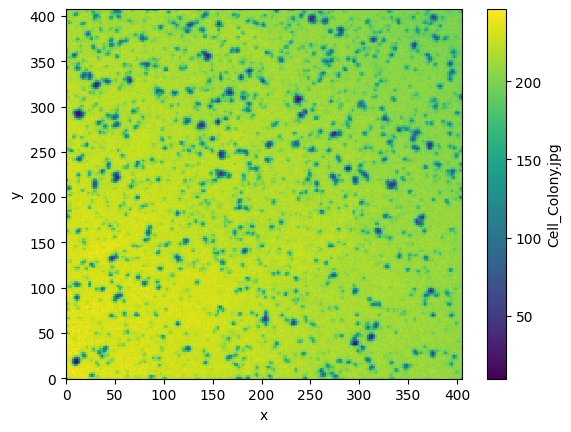

In [13]:
multiscale['scale1'].ds['Cell_Colony.jpg'].plot.imshow()

In [14]:
store = zarr.storage.DirectoryStore('Cell_Colony.zarr', dimension_separator='/')
multiscale.to_zarr(store, mode='w')